# TP 5: Graph cuts for interactive image segmentation

Please upload in time your completed notebook, including your answers and illustrations. You may need to add cells to write your code and comments.

<b> ! Remark ! </b> <br>
I recommend opening, reading and running this notebook <b>on Google Colab </b>rather than VSCode or local jupyter in order to:
- Have the correct formatting of markdowns.
- Be able to visualize the obtained results in the final markdown (that I inserted with github URLs).
- Have a working version of gradio without bugs nor need for supplementary installations (3.50.2).

## Introduction

In this exercise, you will learn how to solve a binary segmentation problem which consists in labeling each pixel of a gray scale image as belonging on the foreground or the background.

To this end, you will build a Markov Random Field (MRF) model for the binary image segmentation problem. Then, you will use a mincut solver in order to minimize the corresponding MRF energy, which will return the segmentation labels of the MRF problem.

Please start by installing the required packages as follows.

In [ ]:
!pip install gradio==3.50.2
!pip install pyMaxFlow

In [ ]:
import os
import PIL
import numpy as np
import gradio as gr
from os import makedirs
from os.path import join

In [ ]:
IMG_DIR = './'
shape_factor = 1.0

# Image file to load
if not os.path.isfile('./coins.jpg'):
  !wget https://www.dropbox.com/s/aw9otqmgrme7m5e/coins.jpg?dl=0 -O coins.jpg

if not os.path.isfile('./fish.jpg'):
  !wget https://www.dropbox.com/s/f3vnd9c1e3he3aw/fish.png?dl=0 -O fish.jpg

# ⚠️ Attention ⚠️
As `IMAGE_TAG` start with `coins.jpg`.
Once your code is operational, switch to `fish.jpg` and perform the same experiments.  
The second image should be much harder and a true test of your method and observations.

In [34]:
IMAGE_TAG = 'fish.jpg'   #'coins.jpg'
IMAGE_NAME = os.path.splitext(IMAGE_TAG)[0]
IMG_PIL = PIL.Image.open(join(IMG_DIR, IMAGE_TAG))
IMG = np.array(IMG_PIL.convert('L'))
IMG_RGB = np.array(IMG_PIL.convert('RGB'))
BINARY_IMG = (IMG > 128).astype(np.uint8) * 255

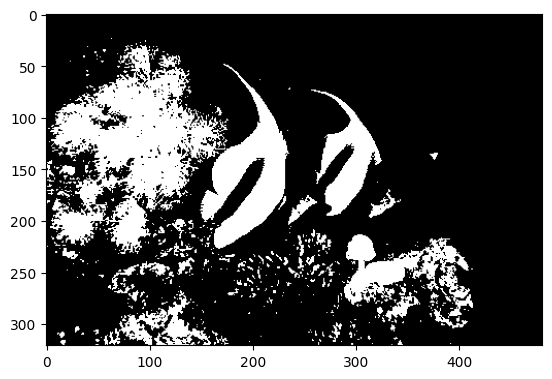

In [35]:
##added by me
import matplotlib.pyplot as plt
plt.imshow(BINARY_IMG, cmap='gray')

## Getting started: Restoration of a noised binary image

First of all, let's take some distance with our initial problem.
In order to better understand how to use the graph cut library, let's focus on a simpler problem: **restoration of noised binary images**.

We denote by $X=\{x_p\} \in \{0, 255\}^{width \times height}$ a gray scale binary image.

Let's say we only have access to a noisy version of $X$, obtained by adding strong Gaussian noise $G$ to the original image:

$$
\hat{X} = X + G
$$

**Given the noisy image $\hat{X}$ as input, the problem consists in denoising $\hat{X}$ in order to recover $X$**.

For this purpose, we use a natural Markov Random Field model (MRF) commonly employed in image analysis:
We first consider each pixel $p$ of the image as a node. Then, for any pair $(p, q)$ of adjacent nodes in the image, we build an undirected edge connecting these two nodes and we write $p \sim q$.

We define $Y = \{y_p\} \in \{0, 1\}^{width \times height}$ as the classification label between white and black pixels in $X$. In particular, we say that $y_p=0$ if the pixel is black, and $y_p=1$ if the pixel is white.

**Our goal is to estimate the true labels $Y$, so that we can recover the original image $X$**.

We define the corresponding MRF enery to minimize as

$$
E(Y|X) = \sum_p D_p(x_p) + \sum_{p\sim q} \lambda |y_p - y_q|
$$

where $D_p$ are the unary potentials.

We should select the potentials in a way that the true classification labels $\tilde{Y}$ minimize the energy $E(Y|X)$ with respect to Y:

$$
\tilde{Y} = \arg \min_Y E(Y|X).
$$


We use L1-distance as binary potentials since it encourages smoothness in the image, as expected from a denoising approach. The value $\lambda$ is the regularization strength: The larger $\lambda$, the smoother the restoration.

Then, we build the unary potentials to encourage pixels to be labeled as black pixels if their color is close to 0, and labeled as white pixels if their color is close to 1:

$$
D_p(x_p) =
\begin{cases}
  x_p & \text{if } y_p=0\\
  255 - x_p & \text{if } y_p=1
\end{cases}
$$

The following function `binary_restore` illustrates how to use the PyMaxFlow library to solve this problem.
Feel free to use the interface provided in the cell just after to experiment with this function and try different values for $\lambda$.

In [36]:
import maxflow as gc
def binary_restore(I, Lambda=50):
    """I: noisy image to be restored.
    Lambda: weight of regularization factor.
    Return the denoised binary image."""
    g = gc.Graph[int]()
    nodeids = g.add_grid_nodes(I.shape)
    g.add_grid_edges(nodeids, Lambda)       # Adds non terminal edges to grid (4-connected by default), with same capacity λ.
    g.add_grid_tedges(nodeids, I, 255-I)    # Set capacities of terminal edges.
    g.maxflow()                             # Find the maximum flow.

    # Get the source/sink label
    labels = g.get_grid_segments(nodeids)
    I2 = np.int_(np.logical_not(labels))
    return (I2*255).astype(np.uint8)

Now, run the following cell and use the interface to experiment with the previous function.

In [37]:
# Interface
def restoration(slider):
    img_clipped = np.clip(BINARY_IMG+np.random.normal(0, 100, BINARY_IMG.shape),0,255).astype(np.uint8)
    img_restored = binary_restore(img_clipped, slider)
    return [img_clipped, img_restored]

with gr.Blocks() as demo:
    with gr.Row():
        input_image = gr.Image(BINARY_IMG, label='Original')
        clipped = gr.Image(None, label='Noisy')
        restored = gr.Image(None, label='Restored')
    slider = gr.Slider(minimum=0, maximum=255, label='slider', value=70)
    restore_button = gr.Button("Restore")

    restore_button.click(restoration, inputs=slider, outputs=[clipped, restored])

demo.launch(share=True) #, debug=True)

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
IMPORTANT: You are using gradio version 3.50.2, however version 4.29.0 is available, please upgrade.
--------
Running on public URL: https://ffeabd9843b8920740.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades, run `gradio deploy` from Terminal to deploy to Spaces (https://huggingface.co/spaces)


#### Question 1

Explain what the function `binary_restore` does, and what the functions of the Graph class do.

<b>My Answer:</b>

→ The <code>binary_restore</code> function takes a noisy image and outputs a denoised version using the maxflow (mincut) method on a graph where each pixel is a node. It aims to minimize the energy and 'restore' the denoised image.

→ Here's what happens in the function:

1. <b>Create Graph</b>: Initializes a graph <code>g</code> with nodes corresponding to each pixel.
2. <b>Add Edges</b>: Adds edges between adjacent pixels with capacity <code>Lambda</code>, encouraging smoothness.
3. <b>Add Terminal Edges</b>: Connects each pixel to the source (black) and sink (white) based on pixel intensity, guiding the classification of pixels.
4. <b>Compute Maxflow</b>: Finds the maximum flow, effectively segmenting the image into black and white regions.
5. <b>Get Segmentation</b>: Retrieves the result, inverting it to match the expected format, and converts it to an 8-bit image.

→ The main functions of the <code>Graph</code> class:

- <code>Graph()</code>: Initializes a new graph.
- <code>add_grid_nodes(shape)</code>: Adds nodes for each pixel in the image.
- <code>add_grid_edges(nodeids, Lambda)</code>: Adds edges between adjacent pixels to promote smoothness.
- <code>add_grid_tedges(nodeids, I, 255-I)</code>: Connects pixels to source and sink based on their intensities and definitions of source and sink.
- <code>maxflow()</code>: Computes the maxflow, segmenting the image.
- <code>get_grid_segments(nodeids)</code>: Retrieves the segmentation result.

This function effectively denoises a binary image by leveraging the graph cut algorithm to classify pixels as either black or white based on their intensities and the smoothness constraint.


## Graph cuts for interactive image segmentation

Let's go back to our initial problem, which consists in solving a binary segmentation problem.
We want to label each pixel of a gray scale image as belonging on the foreground or the background.

We denote by $X=\{x_p\} \in [0, 255]^{width \times height}$ the input gray scale image, and $Y = \{y_p\} \in \{0, 1\}^{width \times height}$ the segmentation result.

In particular, for every pixel $p$, we consider p to be:
- A background pixel if $y_p=0$
- A foreground pixel if $y_p=1$

**The image $X$ is given as an input, and our goal is to estimate the true $Y$, which is unknown.**
For this purpose, we use a Markov Random Field model (MRF) similar to the previous one:
We first consider each pixel $p$ of the image as a node. Then, for any pair $(p, q)$ of adjacent nodes in the image, we build an undirected edge connecting these two nodes and we write $p \sim q$.

The corresponding MRF energy is

$$
E(Y|X) = \sum_p U_p(x_p|y_p) + \sum_{p\sim q} w_{pq} \cdot V_{pq}(y_p, y_q)
$$

where $U_p$ are the unary potentials, $V_{pq}$ the binary potentials and $w_{pq}$ are edge weights.

In order to estimate the segmentation labels, we must minimize the energy $E(Y|X)$ with respect to Y:

$$
\tilde{Y} = \arg \min_Y E(Y|X).
$$

**Your task is to properly define and implement the potentials $U_p, V_{pq}$ as well as the edge weights $w_{pq}$.**

**i) Unary potentials**

If we perfectly knew the probability distribution of colors $\bar{P_0}$ among background pixels as well as the probability distribution of colors $\bar{P_1}$ among foreground pixels, we could compute unary potentials as the opposite of the log-likelihood for both classes:

$$
U_p(x_p|y_p) =
    \begin{cases}
        -\log(k + \bar{P_0}(x_p)), & \text{for } y_p=0 \\
        -\log(k + \bar{P_1}(x_p)), & \text{for } y_p=1
    \end{cases}
$$
with $k=10^{-5}.$

The intuition is the following: If the color $x_p \in [0, 255]$ of a pixel $p$ is a color with high probability $\bar{P_0}(x_p)$ for background pixels, then $p$ is likely to be a background pixel. Therefore, the potential $U_p(y_p=0|x_p)$ should be low.

However, we do not have access to the true distribution of colors.
Instead, you will draw directly on the image using a pencil tool to label a subset of background pixels and a subset of foreground pixels by yourself.

Considering these subsets of labeled pixels are representative of colors of all pixels in both classes, you will compute histograms $P_0$ and $P_1$ of both foreground an background pixels. Then, you will normalize them to obtain probability distributions, and compute the unary potentials as:

$$
U_p(x_p|y_p) =
    \begin{cases}
        -\log(k + P_0[x_p]), & \text{for } y_p=0 \\
        -\log(k + P_1[x_p]), & \text{for } y_p=1
    \end{cases}
$$
with $k=10^{-5}.$

**ii) Binary potentials**

We define the pairwise potentials according to the Potts model $V_{pq}(a, b) = \delta_{a \neq b}$.

**iii) Edge weights**

It is up to you to set the edge weights $w_{pq}$. Throughout the TP, you will test different weights based on different priors.

#### Question 2

Explain the logic behind the expression of the unary potentials $U_p$.

<b>My Answer:</b><br>
The logic behind the unary potentials is to encourage pixels to be labeled as background (0) or foreground (1) based on their intensity values relative to the known characteristics of the foreground and background regions.

- <b>Background Potential ( $y_p$ = 0)</b>:
  - If a pixel \( p \) is more likely to belong to the background (darker regions), its intensity $x_p$ should be lower.
  - The potential $U_p(x_p|y_p=0)$ should therefore increase with increasing intensity, discouraging high-intensity pixels from being labeled as background.

- <b>Foreground Potential ( $y_p$ = 1)</b>:
  - If a pixel p is more likely to belong to the foreground (lighter regions), its intensity $x_p$ should be higher.
  - The potential $U_p(x_p|y_p=1)$ should therefore decrease with increasing intensity, encouraging high-intensity pixels to be labeled as foreground.

The unary potentials can be defined as:
$U_p(x_p|y_p) = \begin{cases}
  x_p & \text{if } y_p = 0 \\
  255 - x_p & \text{if } y_p = 1
\end{cases}$

This formulation guides the segmentation by managing the intensity values, making it more likely that pixels with intensities close to those typical of the background will be labeled as background, and similarly for the foreground.


#### Question 3

In the following cell, write your own `graphcut` function for image segmentation.

Your function should take as inputs:
1. The image `I`
2. A `background` boolean mask indicating which pixels are labeled as *background* by the user
3. A `foreground` boolean mask indicating which pixels are labeled as *foreground* by the user
4. A constant `lamda`. To simplify, we will assign this constant value to all the weights $w_{pq}$ of the graph.

Finally, it should output the segmentation mask `labels`, in which `0` should correspond to background and `255` to foreground.

In the cell just after, the notebook provides you with an interface to label foreground and background pixels by yourself, as well as visualize your segmentation results.
Please note that the interface will automatically save your result in the `./segmentations` directory.

***Hint:*** *To write your function, you have to build the graph, compute the distributions $P_0, P_1$ and assign the weights. Remember that the pre-labeled pixels must keep their label at the end of the graph cut. For that, putting large enough weights to the appropriate terminal nodes ensure that property. Experiment with different values of `lamda`, with the provided image coins.png and other images of your choice.
You can take a look at the interface for further details about how your function should be used.*


In [38]:
def graphcut(I, background, foreground, lamda, **args):
    """graphcut takes input background and foreground masks to samples and performs segmentation using MRF
    Inputs
    ------
      I: np.array with values 0 to 255 and H, W shape corresponding to grayscale image
      background: np.array with same shape as I corresponding to a mask whose positive values indicate some locations of background
      foreground: np.array with same shape as I corresponding to a mask whose positive values indicate some locations of foreground
      lamda: λ parameter as described above
      *args: ignore it for now it is just used to suppress an argument we will use in a following question

    Outputs
    -------
      segmentation: bool array with False for background and True for foreground for the whole image.
    """
    ### Add your code below ###

    # Histograms of background and foreground pixels (normalized --> probability)
    P0 = np.histogram(I[background], bins=256, range=(0, 256), density=True)[0]
    P1 = np.histogram(I[foreground], bins=256, range=(0, 256), density=True)[0]

    # # Normalize histograms to form probability distributions
    # P0 = P0 / np.sum(P0)  #isn't this already done ?
    # P1 = P1 / np.sum(P1)


    # Unary potentials
    k = 1e-5
    U0 = -np.log(k + P0[I])
    U1 = -np.log(k + P1[I])

    # Graph
    g = gc.Graph[float]()
    nodeids = g.add_grid_nodes(I.shape)
    g.add_grid_edges(nodeids, lamda)
    g.add_grid_tedges(nodeids, U0, U1)

    # Large weights for pre-labeled pixels
    large_weight = 1e20
    g.add_grid_tedges(nodeids[background], 0, large_weight)  #weights flipped
    g.add_grid_tedges(nodeids[foreground], large_weight, 0)


    # Perform maxflow
    g.maxflow()

    # Get segmentation labels
    segmentation = g.get_grid_segments(nodeids)

    return segmentation

Here we define a gradio interface that will help us visualize and interact with our model.

In [39]:
def graphcut_interface(background, foreground, lamda, sigma=0):
    # Note!!! if sigma == 0 it should be ignored.
    img, background, foreground = IMG, background['mask'][:, :, 0]>0, foreground['mask'][:, :, 0]>0
    labels = graphcut(img, background, foreground, lamda=lamda, sigma=sigma)

    im = np.copy(IMG_RGB)
    mask = np.zeros_like(im)
    mask[labels,:], mask[~labels,:], = 0, 0       # redundant as mask is initialized to 0
    mask[labels,1], mask[~labels,0], = 255, 255   # 2nd channel (Green) set to 255 --> foreground green /// 1st channel (Red) set to 255 --> background red.
    im = (0.7*im + 0.3*mask).astype(np.uint8)     # Blends the original image with the mask

    # save
    segmentations_dir = join(IMG_DIR, 'segmentations', IMAGE_NAME)
    makedirs(segmentations_dir, exist_ok=True)
    PIL.Image.fromarray(im).save(join(segmentations_dir, f'λ{lamda}_σ{sigma}.png'))

    return im

def launch_demo(has_sigma=False, debug=False, share=False):
    with gr.Blocks() as demo:
        gr.HTML("<h1><center>"
                    "Triva: Graph cuts for interactive image segmentation"
                "</center></h1>")

        gr.HTML("Please draw on the left the foreground of the image and on the right the background.")

        with gr.Row():
            foreground = gr.Image(value=IMG, tool="sketch", interactive=True, label='foreground')
            background = gr.Image(value=IMG, tool="sketch", interactive=True, label='background')
            output = gr.Image(None, label='Segmentation')
        with gr.Row():
            if has_sigma:
                sigma = gr.Slider(minimum=0, maximum=100, value=1, label='σ', step=1)
            lamda = gr.Slider(minimum=1, maximum=10, value=5, label='λ', step=1)

        segment_button = gr.Button("Segment")
        segment_button.click(graphcut_interface, inputs=[foreground, background, lamda] + ([sigma] if has_sigma else []), outputs=output)

    demo.launch(share=share, debug=debug)

Run the following cell to use the provided interface and label foreground and background pixels by yourself, as well as visualize your segmentation results.

In [25]:
launch_demo(debug=False) # debug True will block your cell execution but allows you to visualize implementation errors. Remove it once you are done with debugging.

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
Note: opening Chrome Inspector may crash demo inside Colab notebooks.

To create a public link, set `share=True` in `launch()`.


<IPython.core.display.Javascript object>

#### Question 4

Change the weights $w_{pq}$ so that the cuts along strong edges are not penalized much. Compare with the constant weights.

To do this, add a fifth input `sigma` to your function `graphcut`.
The input `sigma` could be a constant that parametrize the weights of your edges.

***Hint:*** *You will need to use the powerful method* `Graph.add_grid_edges` *(see its documentation on the web)*.

In [40]:
from scipy.ndimage import sobel

def graphcut(I, background, foreground, lamda, sigma):
    """Now define graphcut with sigma
    Note that for sigma == 0 you should run the previous_function
    """
    ### Add your code below ###

    # Histograms of background and foreground pixels (normalized --> probability)
    P0 = np.histogram(I[background], bins=256, range=(0, 256), density=True)[0]
    P1 = np.histogram(I[foreground], bins=256, range=(0, 256), density=True)[0]

    # # Normalizing --> probability distributions
    # P0 = P0 / np.sum(P0)  #isn't this already done ?
    # P1 = P1 / np.sum(P1)

    # Unary potentials
    k = 1e-5
    U0 = -np.log(k + P0[I])
    U1 = -np.log(k + P1[I])

    # Graph
    g = gc.Graph[float]()
    nodeids = g.add_grid_nodes(I.shape)
    g.add_grid_tedges(nodeids, U0, U1)

   # Image gradients using Sobel filter
    grad_x, grad_y = sobel(I.astype(float), axis=0), sobel(I.astype(float), axis=1)
    gradient_magnitude = np.sqrt(grad_x**2 + grad_y**2)
    # Normalizing to [0,1]
    gradient_magnitude = (gradient_magnitude - gradient_magnitude.min()) / (gradient_magnitude.max() - gradient_magnitude.min())
    # print(np.mean(gradient_magnitude)) --> 0.07  ;   # print(np.std(gradient_magnitude)) --> 0.09

    # New edge weights
    coef = 5e-2
    new_lamdas = lamda * np.ones_like(nodeids) * np.exp(- coef * gradient_magnitude * sigma**2)

    # Adding non-terminal edges
    g.add_grid_edges(nodeids, new_lamdas)

    # Adding terminal edges
    large_weight = 1e20
    g.add_grid_tedges(nodeids[background], 0, large_weight)  # Background pixels stay background
    g.add_grid_tedges(nodeids[foreground], large_weight, 0)  # Foreground pixels stay foreground

    g.maxflow()
    segmentation = g.get_grid_segments(nodeids)

    return segmentation


In [42]:
launch_demo(True) #, debug=False

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
Note: opening Chrome Inspector may crash demo inside Colab notebooks.

To create a public link, set `share=True` in `launch()`.


<IPython.core.display.Javascript object>

# ⚠️ Attention ⚠️

All results will be automatically saved under `segmentations/{coins,fish}`.  
Add them below in the form of Markdown, keeping only the important ones and analysing your observations.  
For the best ones include a screenshot of the gradio interface and show it accross different types of segmentation inputs (a bit of masking, a lot of masking vs same amount of masking but in different locations).

# Report

> Please fill here your observation in a structured way. (don't just dump images).

*Example Structure*

## Coins
----


### Without sigma (varying lambda)
Coins are very easy to segment even wihout the sigma factor.<br>
Indeed, the foreground is more distinguishable from the background that in the fish image. And raising lambda shows more smoothness with a best result for $\lambda$=2 (when I input the masks ( * * )). <br>
To show the effect of σ, I chose quasi_empty masks (*) so that results with σ=0 aren't good:
<table>
  <tr>
    <td style="text-align: center;">
      <img src="https://raw.githubusercontent.com/dhia680/Graph_cut_Segmentation/main/Segmentations/Coins/λ1_σ0..png" alt="Segmentation" title="λ1_σ0" style="width: 300px;">
      <p> <b>λ=1 & σ=0 </b></p>
    </td>
    <td style="text-align: center;">
      <img src="https://raw.githubusercontent.com/dhia680/Graph_cut_Segmentation/main/Segmentations/Coins/λ5_σ0..png" alt="Segmentation" title="λ5_σ0" style="width: 300px;">
      <p> <b>λ=5 & σ=0 </b></p>
    </td>
    <td style="text-align: center;">
      <img src="https://raw.githubusercontent.com/dhia680/Graph_cut_Segmentation/main/Segmentations/Coins/λ10_σ0..png" alt="Segmentation" title="λ10_σ0" style="width: 300px;">
      <p> <b>λ=10 & σ=0 </b></p>
    </td>
  </tr>
</table>

### Varying sigma
Even though this factor adds more flexibility on how to segment, it doesn't have a really visible effet in this case of coins especially when we mask all the coins (even imperfectly). Because the image is particularly easy to segment (uniform background and significantly lighter foreground) if there is enough mask.<br>
However, if I <b>mask slightly</b> only some of the coins and do just a little bit of masking for the background, the effect of sigma becomes more visible as it helps capture exact coins and plays a determinant role in segmentation. These results are obtained with <b>slight mask</b> inputs:<br>
<table>
  <tr>
    <td style="text-align: center;">
      <img src="https://raw.githubusercontent.com/dhia680/Graph_cut_Segmentation/main/Segmentations/Coins/λ8_σ8..png" alt="Segmentation for σ8" title="λ8_σ8" style="width: 300px;">
      <p> <b>λ=8 & σ=8 </b></p>
    </td>
    <td style="text-align: center;">
      <img src="https://raw.githubusercontent.com/dhia680/Graph_cut_Segmentation/main/Segmentations/Coins/λ8_σ20..png" alt="Segmentation for σ20" title="λ8_σ20" style="width: 300px;">
      <p> <b>λ=8 & σ=20 </b></p>
    </td>
    <td style="text-align: center;">
      <img src="https://raw.githubusercontent.com/dhia680/Graph_cut_Segmentation/main/Segmentations/Coins/λ8_σ100..png" alt="Segmentation for σ100" title="λ8_σ100" style="width: 300px;">
      <p> <b>λ=8 & σ=100 </b></p>
    </td>
  </tr>
</table>


### Different mask inputs

- A bit of masking (*) with σ = 0:
<img src="https://raw.githubusercontent.com/dhia680/Graph_cut_Segmentation/main/Segmentations/Coins/coin%20%CE%BB5_%CF%830%20%2B%20masks%20(very%20slight%20mask).JPG" alt="Segmentation for σ95" title="λ5_σ95" style="width: 300px;">

- We can see here that a little help by adding masks solves the issue ( * * ):
<img src="https://raw.githubusercontent.com/dhia680/Graph_cut_Segmentation/main/Segmentations/Coins/coin%20%CE%BB5_%CF%830%20%2B%20masks%20(a%20bit%20more%20mask).JPG" alt="Segmentation for σ95" title="λ5_σ95" style="width: 300px;">

### Gradio Screenshot
- The same very light masking (*) with σ = 30 gives a perfect result:
<img src="https://raw.githubusercontent.com/dhia680/Graph_cut_Segmentation/main/Segmentations/Coins/coin%20%CE%BB5_%CF%8330%20%2B%20masks%20(very%20slight%20mask).JPG" alt="Segmentation for σ95" title="λ5_σ95" style="width: 300px;">

<b>P.S:</b> No need to fine tune $\lambda$, a not very low $\lambda$ value (ex. 5) with a fine tuned sigma give optimal results. because sigma plays a role of regularization too.

## Fish
----


### Without sigma
In this case, we get quite good results overall (worse than those of coins of course), especially if we input good masks. <br>
The impact of $\lambda$ is obvious as segmentation gets smoother with higher $\lambda$s. These results are obtained with the very light masks (*):
<table>
  <tr>
    <td style="text-align: center;">
      <img src="https://raw.githubusercontent.com/dhia680/Graph_cut_Segmentation/main/Segmentations/Fishs/λ1_σ0.png" alt="Segmentation for σ0" title="λ1_σ0" style="width: 300px;">
      <p> <b>λ=1 & σ=0 </b></p>
    </td>
    <td style="text-align: center;">
      <img src="https://raw.githubusercontent.com/dhia680/Graph_cut_Segmentation/main/Segmentations/Fishs/λ5_σ0.png" alt="Segmentation for σ0" title="λ5_σ0" style="width: 300px;">
      <p> <b>λ=5 & σ=0 </b></p>
    </td>
    <td style="text-align: center;">
      <img src="https://raw.githubusercontent.com/dhia680/Graph_cut_Segmentation/main/Segmentations/Fishs/λ10_σ0.png" alt="Segmentation for σ0" title="λ10_σ0" style="width: 300px;">
      <p> <b>λ=10 & σ=0 </b></p>
    </td>
  </tr>
</table>


### Varying sigma
To capture strong edges and encode the behaviour of less penalization for these edges, I opted for the idea of computing <b>gradient magnitudes</b> with a fast predefined scipy method, then normalize them, then multipying the initial penalty lambda <b>for each pixel</b> by some variable exponential coefficient (in [0,1]).

The coefficients decrease when gradient magnitude goes up (i.e for strong edges) which makes this method more robust as we can control regularization depending on the strength of the edge and not uniformly for all pixels.

For all pixels, these coefficients ```exp(- coef * gradient_magnitude(pixel) * sigma**2)``` go down considerably (thus we penalize even less strong edges) when sigma increases, encoding the looked for behaviour for sigma ($\sigma ⇑$, penalization of strong edges $⇓$). <br>
The reason I added ```coef *``` is to scale the values (to have moderate effect of sigma) because ```gradient_magnitude```, after normalization, are between 0 and 1, multiplying by $\sigma^2 \sim 10^3, 10^4$, this would give an ```exp``` coefficient $\sim$ 0 for most sigma values.

This amelioration has a visible positive effect on segmentation (more sensitivity). These are obtained with very light input masks (*):
<table>
  <tr>
    <td style="text-align: center;">
      <img src="https://raw.githubusercontent.com/dhia680/Graph_cut_Segmentation/main/Segmentations/Fishs/λ10_σ30.png" alt="Segmentation for σ30" title="λ10_σ30" style="width: 300px;">
      <p> <b>λ=10 & σ=30 </b></p>
    </td>
    <td style="text-align: center;">
      <img src="https://raw.githubusercontent.com/dhia680/Graph_cut_Segmentation/main/Segmentations/Fishs/λ10_σ90.png" alt="Segmentation for σ90" title="λ10_σ90" style="width: 300px;">
      <p> <b>λ=10 & σ=90 </b></p>
    </td>
  </tr>
</table>

### Different mask inputs
For light masks, we're able to segment a bit more domain but some difficult parts are still very difficult to segment without adding more mask. <br>
However, it's worth mentionning that with the right $(\sigma, \lambda)$ couple choosen, some 'hardly segmentable' regions can be segmented by adding just a very small mask (a simple click for ex.). <br>
That's the case for the black lines on the two fishes. Here is a result for light input masks (*):
<img src="https://raw.githubusercontent.com/dhia680/Graph_cut_Segmentation/main/Segmentations/Fishs/fish%20λ10_σ90%20+%20masks%20(very%20light%20mask).JPG" alt="Segmentation for σ95" title="λ5_σ95" style="width: 300px;">

With <b>more masking of background</b> we can get:
<img src="https://raw.githubusercontent.com/dhia680/Graph_cut_Segmentation/main/Segmentations/Fishs/fish%20λ10_σ90%20+%20masks%20(best%20lot%20of%20mask).JPG" alt="Segmentation for σ95" title="λ5_σ95" style="width: 300px;">


### Gradio Screenshot
The best approach is to fix a high value of λ (between 5 and 10) and raise gradually σ.

This will adjust the penalties and lower them especially for strong edges.
A final good result with just a bit of mask is the following:
<img src="https://raw.githubusercontent.com/dhia680/Graph_cut_Segmentation/main/Segmentations/Fishs/fish%20λ10_σ90%20+%20masks%20(best%20light%20mask).JPG" alt="Segmentation for σ95" title="λ5_σ95" style="width: 300px;">